# Klasifikasi Text Mining menggunakan Naive Bayes
**Restu Lestari Mulianingrum (A11.2022.14668)**

## install library ekphrasis

In [1]:
# !pip install ekphrasis

In [2]:
from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons

text_processor = TextPreProcessor(
    # terms that will be normalized
    normalize=['email', 'percent', 'money', 'phone', 'user',
        'time', 'date', 'number'],
    # terms that will be annotated
    #annotate={"hashtag", "allcaps", "elongated", "repeated",'emphasis', 'censored'},
    annotate={"hashtag","allcaps","elongated","repeated",'emphasis','censored'},
    fix_html=True,  # fix HTML tokens
    
    # corpus from which the word statistics are going to be used 
    # for word segmentation 
    segmenter="twitter", 
    
    # corpus from which the word statistics are going to be used 
    # for spell correction
    corrector="twitter", 
    
    unpack_hashtags=True,  # perform word segmentation on hashtags
    unpack_contractions=True,  # Unpack contractions (can't -> can not)
    spell_correct_elong=False,  # spell correction for elongated words
    
    # select a tokenizer. You can use SocialTokenizer, or pass your own
    # the tokenizer, should take as input a string and return a list of tokens
    tokenizer=SocialTokenizer(lowercase=True).tokenize,
    
    # list of dictionaries, for replacing tokens extracted from the text,
    # with other expressions. You can pass more than one dictionaries.
    dicts=[emoticons]
)

C:\Users\RESTU\AppData\Local\Programs\Python\Python312\Lib\site-packages\ekphrasis\classes\tokenizer.py:225: FutureWarning: Possible nested set at position 2190
  self.tok = re.compile(r"({})".format("|".join(pipeline)))


Reading twitter - 1grams ...
Reading twitter - 2grams ...
Reading twitter - 1grams ...


C:\Users\RESTU\AppData\Local\Programs\Python\Python312\Lib\site-packages\ekphrasis\classes\exmanager.py:14: FutureWarning: Possible nested set at position 42
  regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


## load library

In [3]:
import re
import string 
import pandas as pd
from copy import deepcopy

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

## load dataset

In [4]:
df = pd.read_csv('review_dana_labelled.csv')

In [5]:
df.head()

userName  score                   at  \
0     Elisya Kasni      5  2024-02-15 11:24:56   
1       Rusman Man      2  2024-02-15 11:24:03   
2     Qiliw Sadega      1  2024-02-15 11:23:34   
3  Kijutjrv2 Kijut      3  2024-02-15 11:22:46   
4     Fifi Alfiyah      1  2024-02-15 11:21:34   

                                             content  sentimen  
0                                              Bagus  POSITIVE  
1                             Dana mmg keren mantap.  POSITIVE  
2  Saya ngajuin upgrade dana premium krna ktp say...  NEGATIVE  
3  Kocak mana diskon nya ml malah eror segala kag...  NEGATIVE  
4  Saldo hilang karena no lama Hilang ganti no sa...  NEGATIVE

In [6]:
df = df.drop(['at', 'score', 'userName'], axis=1)

In [7]:
df.head()

content  sentimen
0                                              Bagus  POSITIVE
1                             Dana mmg keren mantap.  POSITIVE
2  Saya ngajuin upgrade dana premium krna ktp say...  NEGATIVE
3  Kocak mana diskon nya ml malah eror segala kag...  NEGATIVE
4  Saldo hilang karena no lama Hilang ganti no sa...  NEGATIVE

## Preprocessing

In [8]:
import re
import string

def bersih_data(text):
    return " ".join(text_processor.pre_process_doc(text))

def non_ascii(text):
    return text.encode('ascii', 'replace').decode('ascii')

def remove_space_alzami(text):
    return " ".join(text.split())

def remove_emoji_alzami(text):
    return ' '.join(re.sub("([x#][A-Za-z0-9]+)"," ", text).split())

def remove_tab(text):
    return text.replace('\\t'," ").replace('\\n'," ").replace('\\u'," ").replace('\\',"")

def remove_tab2(text):
    return re.sub(r'\s+', ' ', text)

def remove_rt(text):
    return text.replace('RT', "")

def remove_mention(text):
    return ' '.join(re.sub(r"([@#][\w]+)|(\w+:\/\/\S+)", " ", text).split())

def remove_incomplete_url(text):
    return text.replace("http://", " ").replace("https://", " ")

def remove_single_char(text):
    return re.sub(r"\b[a-zA-Z]\b", "", text)

def change_stripe(text):
    return text.replace('-', " ")

def lower(text):
    return text.lower()

def remove_punctuation(text):
    remove = string.punctuation
    remove = remove.replace("_", "") # don't remove hyphens
    pattern = r"[{}]".format(remove) # create the pattern
    return re.sub(pattern, "", text) 


## running preprocessing

In [9]:
final_string = []
for text in df['content'].values:
    EachReviewText = ""
    proc = bersih_data(text)
    proc = remove_rt(proc) 
    proc = lower(proc)
    proc = change_stripe(proc)
    proc = remove_tab(proc)
    proc = remove_tab2(proc)
    proc = non_ascii(proc)
    proc = remove_incomplete_url(proc)
    proc = remove_single_char(proc)
    proc = remove_punctuation(proc)
    proc = remove_space_alzami(proc)
    EachReviewText = proc
    final_string.append(EachReviewText)

In [10]:
df["step01"] = final_string

In [11]:
df.head(1)

content  sentimen step01
0   Bagus  POSITIVE  bagus

## Cek jumlah dataset

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   content   50000 non-null  object
 1   sentimen  50000 non-null  object
 2   step01    50000 non-null  object
dtypes: object(3)
memory usage: 1.1+ MB


## hapus record yang kosong

In [13]:
df_hapus = df[~df['step01'].str.contains(" ")]

In [14]:
df_new = df[~df.isin(df_hapus)].dropna()

In [15]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36169 entries, 1 to 49998
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   content   36169 non-null  object
 1   sentimen  36169 non-null  object
 2   step01    36169 non-null  object
dtypes: object(3)
memory usage: 1.1+ MB


## normalisasi kata slang

In [16]:
# token
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize 

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\RESTU\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [17]:
def word_tokenize_wrapper(text):
  return word_tokenize(text)

In [18]:
df_new['tokens'] = df['step01'].apply(word_tokenize_wrapper)

In [19]:
df_new.head(10)

content  sentimen  \
1                              Dana mmg keren mantap.  POSITIVE   
2   Saya ngajuin upgrade dana premium krna ktp say...  NEGATIVE   
3   Kocak mana diskon nya ml malah eror segala kag...  NEGATIVE   
4   Saldo hilang karena no lama Hilang ganti no sa...  NEGATIVE   
6   Udah gua hapus dana ya. ilang ya udah 1 juta l...  NEGATIVE   
8   TOLONG UNTUK SISTEM KEAMANAN DI PERBAIKI. KALA...   NEUTRAL   
9                                mempermudah transfer  POSITIVE   
10  baru yobain semoga aman sentosa tidak pembobol...   NEUTRAL   
11                                kok gx bisa keridit  NEGATIVE   
12                                        sangat puas  POSITIVE   

                                               step01  \
1                               dana mmg keren mantap   
2   saya ngajuin upgrade dana premium krna ktp say...   
3   kocak mana diskon nya ml malah eror segala kag...   
4   saldo hilang karena no lama hilang ganti no sa...   
6   udah gua hapus dana ya ilang ya udah number ju...   
8   allcaps tolong untuk sistem keamanan di perbai...   
9                                mempermudah transfer   
10  baru yobain semoga aman sentosa tidak pembobol...   
11                                kok gx bisa keridit   
12                                        sangat puas   

                                               tokens  
1                          [dana, mmg, keren, mantap]  
2   [saya, ngajuin, upgrade, dana, premium, krna, ...  
3   [kocak, mana, diskon, nya, ml, malah, eror, se...  
4   [saldo, hilang, karena, no, lama, hilang, gant...  
6   [udah, gua, hapus, dana, ya, ilang, ya, udah, ...  
8   [allcaps, tolong, untuk, sistem, keamanan, di,...  
9                             [mempermudah, transfer]  
10  [baru, yobain, semoga, aman, sentosa, tidak, p...  
11                           [kok, gx, bisa, keridit]  
12                                     [sangat, puas]

In [20]:
#!pip install openpyxl

In [21]:
normalized_word = pd.read_excel("kamus perbaikan kata.xlsx")

In [22]:
normalized_word_dict = {}

for index, row in normalized_word.iterrows():
    if row[0] not in normalized_word_dict:
        normalized_word_dict[row[0]] = row[1] 

def normalized_term(document):
    return [normalized_word_dict[term] if term in normalized_word_dict else term for term in document]

df_new['tokens_perbaikan'] = df_new['tokens'].apply(normalized_term)

C:\Users\RESTU\AppData\Local\Temp\ipykernel_27504\3300841433.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if row[0] not in normalized_word_dict:
C:\Users\RESTU\AppData\Local\Temp\ipykernel_27504\3300841433.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  normalized_word_dict[row[0]] = row[1]


In [23]:
df_new.head()

content  sentimen  \
1                             Dana mmg keren mantap.  POSITIVE   
2  Saya ngajuin upgrade dana premium krna ktp say...  NEGATIVE   
3  Kocak mana diskon nya ml malah eror segala kag...  NEGATIVE   
4  Saldo hilang karena no lama Hilang ganti no sa...  NEGATIVE   
6  Udah gua hapus dana ya. ilang ya udah 1 juta l...  NEGATIVE   

                                              step01  \
1                              dana mmg keren mantap   
2  saya ngajuin upgrade dana premium krna ktp say...   
3  kocak mana diskon nya ml malah eror segala kag...   
4  saldo hilang karena no lama hilang ganti no sa...   
6  udah gua hapus dana ya ilang ya udah number ju...   

                                              tokens  \
1                         [dana, mmg, keren, mantap]   
2  [saya, ngajuin, upgrade, dana, premium, krna, ...   
3  [kocak, mana, diskon, nya, ml, malah, eror, se...   
4  [saldo, hilang, karena, no, lama, hilang, gant...   
6  [udah, gua, hapus, dana, ya, ilang, ya, udah, ...   

                                    tokens_perbaikan  
1                      [dana, memang, keren, mantap]  
2  [saya, mengajukan, upgrade, dana, premium, kar...  
3  [kocak, mana, diskon, nya, mobile legends, mal...  
4  [saldo, hilang, karena, no, lama, hilang, gant...  
6  [sudah, saya, hapus, dana, iya, hilang, iya, s...

In [24]:
df_new.iloc[0].tokens

['dana', 'mmg', 'keren', 'mantap']

In [25]:
df_new.iloc[0].tokens_perbaikan

['dana', 'memang', 'keren', 'mantap']

## Stopword - Menggunakan Modul NLTK

In [26]:
from nltk.corpus import stopwords
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\RESTU\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [27]:
stopword = nltk.corpus.stopwords.words('indonesian')

def remove_stopwords(text):
  text = [word for word in text if word not in stopword]
  return text

df_new['Stop_removal'] = df_new['tokens_perbaikan'].apply(lambda x: remove_stopwords(x))
df_new

content  sentimen  \
1                                 Dana mmg keren mantap.  POSITIVE   
2      Saya ngajuin upgrade dana premium krna ktp say...  NEGATIVE   
3      Kocak mana diskon nya ml malah eror segala kag...  NEGATIVE   
4      Saldo hilang karena no lama Hilang ganti no sa...  NEGATIVE   
6      Udah gua hapus dana ya. ilang ya udah 1 juta l...  NEGATIVE   
...                                                  ...       ...   
49993  Amanah, biasanya kerja juga pake apk dana buat...   NEUTRAL   
49994  Kak tolong perbaiki dana saya, Karena tidak mu...   NEUTRAL   
49996                            error, tidak bisa masuk  NEGATIVE   
49997                                     Cukup membantu  POSITIVE   
49998  tolong pihak dana knp saldo saya hilang,ada yg...   NEUTRAL   

                                                  step01  \
1                                  dana mmg keren mantap   
2      saya ngajuin upgrade dana premium krna ktp say...   
3      kocak mana diskon nya ml malah eror segala kag...   
4      saldo hilang karena no lama hilang ganti no sa...   
6      udah gua hapus dana ya ilang ya udah number ju...   
...                                                  ...   
49993  amanah biasanya kerja juga pake apk dana buat ...   
49994  kak tolong perbaiki dana saya karena tidak mun...   
49996                             error tidak bisa masuk   
49997                                     cukup membantu   
49998  tolong pihak dana knp saldo saya hilang ada yg...   

                                                  tokens  \
1                             [dana, mmg, keren, mantap]   
2      [saya, ngajuin, upgrade, dana, premium, krna, ...   
3      [kocak, mana, diskon, nya, ml, malah, eror, se...   
4      [saldo, hilang, karena, no, lama, hilang, gant...   
6      [udah, gua, hapus, dana, ya, ilang, ya, udah, ...   
...                                                  ...   
49993  [amanah, biasanya, kerja, juga, pake, apk, dan...   
49994  [kak, tolong, perbaiki, dana, saya, karena, ti...   
49996                        [error, tidak, bisa, masuk]   
49997                                  [cukup, membantu]   
49998  [tolong, pihak, dana, knp, saldo, saya, hilang...   

                                        tokens_perbaikan  \
1                          [dana, memang, keren, mantap]   
2      [saya, mengajukan, upgrade, dana, premium, kar...   
3      [kocak, mana, diskon, nya, mobile legends, mal...   
4      [saldo, hilang, karena, no, lama, hilang, gant...   
6      [sudah, saya, hapus, dana, iya, hilang, iya, s...   
...                                                  ...   
49993  [amanah, biasanya, kerja, juga, pakai, apk, da...   
49994  [kak, tolong, perbaiki, dana, saya, karena, ti...   
49996                        [error, tidak, bisa, masuk]   
49997                                  [cukup, membantu]   
49998  [tolong, pihak, dana, mengapa, saldo, saya, hi...   

                                            Stop_removal  
1                                  [dana, keren, mantap]  
2      [mengajukan, upgrade, dana, premium, ktp, bura...  
3      [kocak, diskon, nya, mobile legends, eror, kag...  
4      [saldo, hilang, no, hilang, ganti, no, saldony...  
6      [hapus, dana, iya, hilang, iya, number, juta, ...  
...                                                  ...  
49993  [amanah, kerja, pakai, apk, dana, ngisi, uang,...  
49994  [kak, tolong, perbaiki, dana, muncul, dana, pa...  
49996                                     [error, masuk]  
49997                                         [membantu]  
49998  [tolong, dana, saldo, hilang, bobol, akun, ora...  

[36169 rows x 6 columns]

In [28]:
df_new.iloc[0].tokens_perbaikan

['dana', 'memang', 'keren', 'mantap']

In [29]:
df_new.iloc[0].Stop_removal

['dana', 'keren', 'mantap']

In [30]:
i=0
final_string_tokens = []
for text in df_new['Stop_removal'].values:
    EachReviewText = ""
    EachReviewText = ' '.join(text)
    final_string_tokens.append(EachReviewText)

In [31]:
df_new["step02"] = final_string_tokens

In [32]:
df_new.head()

content  sentimen  \
1                             Dana mmg keren mantap.  POSITIVE   
2  Saya ngajuin upgrade dana premium krna ktp say...  NEGATIVE   
3  Kocak mana diskon nya ml malah eror segala kag...  NEGATIVE   
4  Saldo hilang karena no lama Hilang ganti no sa...  NEGATIVE   
6  Udah gua hapus dana ya. ilang ya udah 1 juta l...  NEGATIVE   

                                              step01  \
1                              dana mmg keren mantap   
2  saya ngajuin upgrade dana premium krna ktp say...   
3  kocak mana diskon nya ml malah eror segala kag...   
4  saldo hilang karena no lama hilang ganti no sa...   
6  udah gua hapus dana ya ilang ya udah number ju...   

                                              tokens  \
1                         [dana, mmg, keren, mantap]   
2  [saya, ngajuin, upgrade, dana, premium, krna, ...   
3  [kocak, mana, diskon, nya, ml, malah, eror, se...   
4  [saldo, hilang, karena, no, lama, hilang, gant...   
6  [udah, gua, hapus, dana, ya, ilang, ya, udah, ...   

                                    tokens_perbaikan  \
1                      [dana, memang, keren, mantap]   
2  [saya, mengajukan, upgrade, dana, premium, kar...   
3  [kocak, mana, diskon, nya, mobile legends, mal...   
4  [saldo, hilang, karena, no, lama, hilang, gant...   
6  [sudah, saya, hapus, dana, iya, hilang, iya, s...   

                                        Stop_removal  \
1                              [dana, keren, mantap]   
2  [mengajukan, upgrade, dana, premium, ktp, bura...   
3  [kocak, diskon, nya, mobile legends, eror, kag...   
4  [saldo, hilang, no, hilang, ganti, no, saldony...   
6  [hapus, dana, iya, hilang, iya, number, juta, ...   

                                              step02  
1                                  dana keren mantap  
2  mengajukan upgrade dana premium ktp buram veri...  
3  kocak diskon nya mobile legends eror kaga ikhl...  
4  saldo hilang no hilang ganti no saldonya dana ...  
6  hapus dana iya hilang iya number juta duit mf ...

## Stemming - Menggunakan Sastrawi

In [33]:
# !pip install sastrawi

In [34]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [35]:
final_string = []
s = ""
for sentence in df_new["step02"].values:
    filteredSentence = []
    EachReviewText = ""
    s = (stemmer.stem(sentence))
    filteredSentence.append(s)
    
    EachReviewText = ' '.join(filteredSentence)
    final_string.append(EachReviewText)

In [36]:
df_new["ProcessedText"] = final_string

In [37]:
df_new.head(10)

content  sentimen  \
1                              Dana mmg keren mantap.  POSITIVE   
2   Saya ngajuin upgrade dana premium krna ktp say...  NEGATIVE   
3   Kocak mana diskon nya ml malah eror segala kag...  NEGATIVE   
4   Saldo hilang karena no lama Hilang ganti no sa...  NEGATIVE   
6   Udah gua hapus dana ya. ilang ya udah 1 juta l...  NEGATIVE   
8   TOLONG UNTUK SISTEM KEAMANAN DI PERBAIKI. KALA...   NEUTRAL   
9                                mempermudah transfer  POSITIVE   
10  baru yobain semoga aman sentosa tidak pembobol...   NEUTRAL   
11                                kok gx bisa keridit  NEGATIVE   
12                                        sangat puas  POSITIVE   

                                               step01  \
1                               dana mmg keren mantap   
2   saya ngajuin upgrade dana premium krna ktp say...   
3   kocak mana diskon nya ml malah eror segala kag...   
4   saldo hilang karena no lama hilang ganti no sa...   
6   udah gua hapus dana ya ilang ya udah number ju...   
8   allcaps tolong untuk sistem keamanan di perbai...   
9                                mempermudah transfer   
10  baru yobain semoga aman sentosa tidak pembobol...   
11                                kok gx bisa keridit   
12                                        sangat puas   

                                               tokens  \
1                          [dana, mmg, keren, mantap]   
2   [saya, ngajuin, upgrade, dana, premium, krna, ...   
3   [kocak, mana, diskon, nya, ml, malah, eror, se...   
4   [saldo, hilang, karena, no, lama, hilang, gant...   
6   [udah, gua, hapus, dana, ya, ilang, ya, udah, ...   
8   [allcaps, tolong, untuk, sistem, keamanan, di,...   
9                             [mempermudah, transfer]   
10  [baru, yobain, semoga, aman, sentosa, tidak, p...   
11                           [kok, gx, bisa, keridit]   
12                                     [sangat, puas]   

                                     tokens_perbaikan  \
1                       [dana, memang, keren, mantap]   
2   [saya, mengajukan, upgrade, dana, premium, kar...   
3   [kocak, mana, diskon, nya, mobile legends, mal...   
4   [saldo, hilang, karena, no, lama, hilang, gant...   
6   [sudah, saya, hapus, dana, iya, hilang, iya, s...   
8   [allcaps, tolong, untuk, sistem, keamanan, di,...   
9                             [mempermudah, transfer]   
10  [baru, yobain, semoga, aman, sentosa, tidak, p...   
11                          [kok, gak, bisa, keridit]   
12                                     [sangat, puas]   

                                         Stop_removal  \
1                               [dana, keren, mantap]   
2   [mengajukan, upgrade, dana, premium, ktp, bura...   
3   [kocak, diskon, nya, mobile legends, eror, kag...   
4   [saldo, hilang, no, hilang, ganti, no, saldony...   
6   [hapus, dana, iya, hilang, iya, number, juta, ...   
8   [allcaps, tolong, sistem, keamanan, perbaiki, ...   
9                             [mempermudah, transfer]   
10  [yobain, semoga, aman, sentosa, pembobolan, ap...   
11                                     [gak, keridit]   
12                                             [puas]   

                                               step02  \
1                                   dana keren mantap   
2   mengajukan upgrade dana premium ktp buram veri...   
3   kocak diskon nya mobile legends eror kaga ikhl...   
4   saldo hilang no hilang ganti no saldonya dana ...   
6   hapus dana iya hilang iya number juta duit mf ...   
8   allcaps tolong sistem keamanan perbaiki allcap...   
9                                mempermudah transfer   
10  yobain semoga aman sentosa pembobolan apk sebelah   
11                                        gak keridit   
12                                               puas   

                                        ProcessedText  
1                                   dana keren mantap  
2   aju upgrade dana premium ktp buram verifikasi ...  


## simpan hasil preprocessing

In [38]:
df_new.to_csv('clean_dataset_part01.csv',sep=";")

# Penataan Data

## pembagian fitur dan label

In [39]:
dataset = pd.read_csv('clean_dataset_part01.csv',sep=";")

In [40]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36169 entries, 0 to 36168
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        36169 non-null  int64 
 1   content           36169 non-null  object
 2   sentimen          36169 non-null  object
 3   step01            36169 non-null  object
 4   tokens            36169 non-null  object
 5   tokens_perbaikan  36169 non-null  object
 6   Stop_removal      36169 non-null  object
 7   step02            35321 non-null  object
 8   ProcessedText     35321 non-null  object
dtypes: int64(1), object(8)
memory usage: 2.5+ MB


In [41]:
dataset_feature = dataset['ProcessedText'].astype(str)

In [42]:
dataset_feature.head(10)

0                                    dana keren mantap
1    aju upgrade dana premium ktp buram verifikasi ...
2    kocak diskon nya mobile legends eror kaga ikhl...
3    saldo hilang no hilang ganti no saldo dana tan...
4    hapus dana iya hilang iya number juta duit mf ...
5    allcaps tolong sistem aman baik allcaps allcap...
6                                       mudah transfer
7             yobain moga aman sentosa bobol apk belah
8                                          gak keridit
9                                                 puas
Name: ProcessedText, dtype: object

In [43]:
dataset_label = dataset['sentimen']

In [44]:
dataset_label.head(10)

0    POSITIVE
1    NEGATIVE
2    NEGATIVE
3    NEGATIVE
4    NEGATIVE
5     NEUTRAL
6    POSITIVE
7     NEUTRAL
8    NEGATIVE
9    POSITIVE
Name: sentimen, dtype: object

## Encoding
Tujuan encoding pada data kategorikal seperti variabel "sentimen" adalah untuk mengubah nilai-nilai kategori menjadi bentuk yang dapat diolah

In [45]:
from sklearn.preprocessing import LabelEncoder

# Instantiate the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the target variable
encoded_labels = label_encoder.fit_transform(dataset_label)

# Print the encoded labels
print(encoded_labels)


[2 0 0 ... 0 2 1]


## distribusi label

C:\Users\RESTU\AppData\Local\Temp\ipykernel_27504\2336506259.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(encoded_labels_series, label=f'target, skew: {encoded_labels_series.skew():.2f}')


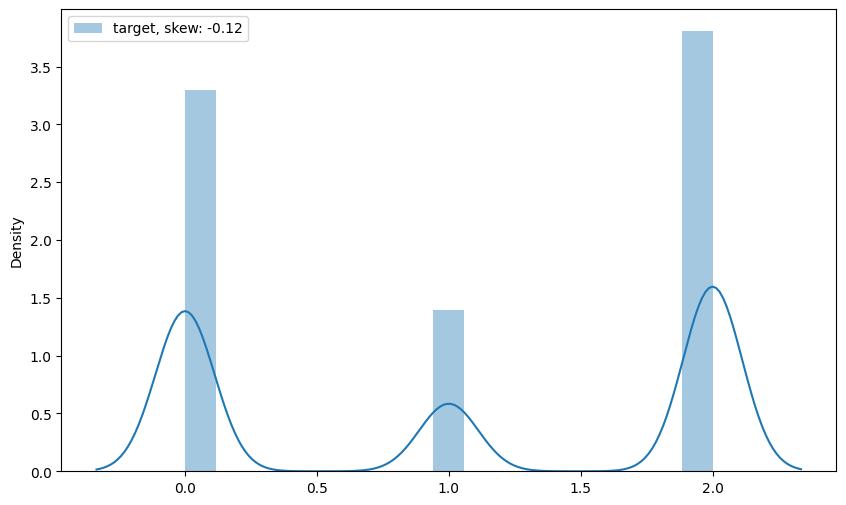

In [46]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Convert encoded_labels (NumPy array) back to pandas Series
encoded_labels_series = pd.Series(encoded_labels)

# Visualize the target variable
plt.figure(figsize=(10, 6))
sns.distplot(encoded_labels_series, label=f'target, skew: {encoded_labels_series.skew():.2f}')
plt.legend(loc='best')
plt.show()


In [47]:
encoded_labels_series.value_counts()

2    16195
0    14050
1     5924
Name: count, dtype: int64

# Ekstraksi Fitur dan Machine Learning

In [48]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.model_selection import train_test_split

In [49]:
train_x, test_x, train_label, test_label = train_test_split(dataset_feature, dataset_label, test_size = 0.3, random_state=42)

In [50]:
test_x

8742                                 mohon baik apk dana
23053                                                nan
18530                        gajelas sumpah gabisa login
263                                         tap aplikasi
36002                                              bantu
                              ...                       
14771                                        kirim cepat
11868    jelek saldo dana tiba2 hilang bantu ana tanggap
2790                                               bagus
18498                       abgred verivikasi kirim uang
6309                                       sip elongated
Name: ProcessedText, Length: 10851, dtype: object

## load TF-IDF

In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer
Tfidf_Vectorizer = TfidfVectorizer()

## Naive Bayes

In [52]:
#pip install naive-bayes

In [53]:
from sklearn.naive_bayes import MultinomialNB

In [54]:
from sklearn.pipeline import Pipeline
classifier_nb = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('model', MultinomialNB()),
])

In [55]:
parameters_nb = {
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4)],
    'model__alpha': (0.0001, 0.001, 0.1, 1, 10, 100)
}

In [56]:
classifier_nb = GridSearchCV(classifier_nb, parameters_nb, cv = 3, n_jobs=-1)

In [57]:
classifier_nb.fit(train_x, train_label.ravel())

C:\Users\RESTU\AppData\Local\Temp\ipykernel_27504\4039834798.py:1: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  classifier_nb.fit(train_x, train_label.ravel())


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('model', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'model__alpha': (0.0001, 0.001, 0.1, 1, 10, 100),
                         'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3),
                                                (1, 4)]})

In [58]:
y_pred_nb_train = classifier_nb.predict(train_x)
accuracy_nb_train = accuracy_score(train_label, y_pred_nb_train)
print("Accuracy Training set: ", accuracy_nb_train)

y_pred_nb_test = classifier_nb.predict(test_x)
accuracy_nb_test = accuracy_score(test_label, y_pred_nb_test)
print("Accuracy Test set: ", accuracy_nb_test)

Accuracy Training set:  0.954301287621455
Accuracy Test set:  0.7802967468436088


In [59]:
recall_nb_train = recall_score(train_label, y_pred_nb_train, average='weighted')
print("Recall Training set: ", recall_nb_train)

recall_nb_test = recall_score(test_label, y_pred_nb_test, average='weighted')
print("Recall Test set: ", recall_nb_test)

Recall Training set:  0.954301287621455
Recall Test set:  0.7802967468436088


In [60]:
precision_nb_train = precision_score(train_label, y_pred_nb_train, average='weighted')
print("Precision Training set: ", precision_nb_train)

precision_nb_test = precision_score(test_label, y_pred_nb_test, average='weighted')
print("Precision Test set: ", precision_nb_test)

Precision Training set:  0.9551296363355666
Precision Test set:  0.7693741112924738


In [61]:
f1_nb_train = f1_score(train_label, y_pred_nb_train, average='weighted')
print("F1 Training set: ", f1_nb_train)

f1_nb_test = f1_score(test_label, y_pred_nb_test, average='weighted')
print("F1 Test set: ", f1_nb_test)

F1 Training set:  0.9538908296325587
F1 Test set:  0.7476136938639548


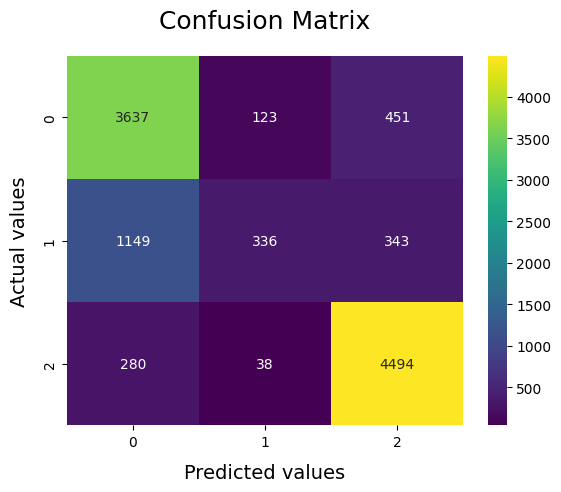

In [62]:
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(test_label, y_pred_nb_test), annot=True, cmap = 'viridis', fmt='.0f')
plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)
plt.show()

In [63]:
classifier_nb.best_estimator_

Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 3))),
                ('model', MultinomialNB(alpha=0.1))])

In [64]:
for param_name in sorted(parameters_nb.keys()):
    print("%s: %r" % (param_name, classifier_nb.best_params_[param_name]))

model__alpha: 0.1
tfidf__ngram_range: (1, 3)


# Visualisasi

In [65]:
models = [        
          ('Naive Bayes Multinomial', accuracy_nb_train, accuracy_nb_test),
         ]

In [66]:
predict = pd.DataFrame(data = models, columns=['Model', 'Training Accuracy', 'Test Accuracy'])
predict

Model  Training Accuracy  Test Accuracy
0  Naive Bayes Multinomial           0.954301       0.780297

In [67]:
models_comparison = [                        
                        ('Naive Bayes Multinomial', accuracy_nb_test, recall_nb_test, precision_nb_test, f1_nb_test)                      
                    ]

In [68]:
comparison = pd.DataFrame(data = models_comparison, columns=['Model', 'Accuracy', 'Recall', 'Precision', 'F1 Weighted'])
comparison

Model  Accuracy    Recall  Precision  F1 Weighted
0  Naive Bayes Multinomial  0.780297  0.780297   0.769374     0.747614

C:\Users\RESTU\AppData\Local\Temp\ipykernel_27504\2750282873.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Training Accuracy', y='Model', data = predict, palette='Blues_d', ax = axes[0])
C:\Users\RESTU\AppData\Local\Temp\ipykernel_27504\2750282873.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Test Accuracy', y='Model', data = predict, palette='Greens_d', ax = axes[1])


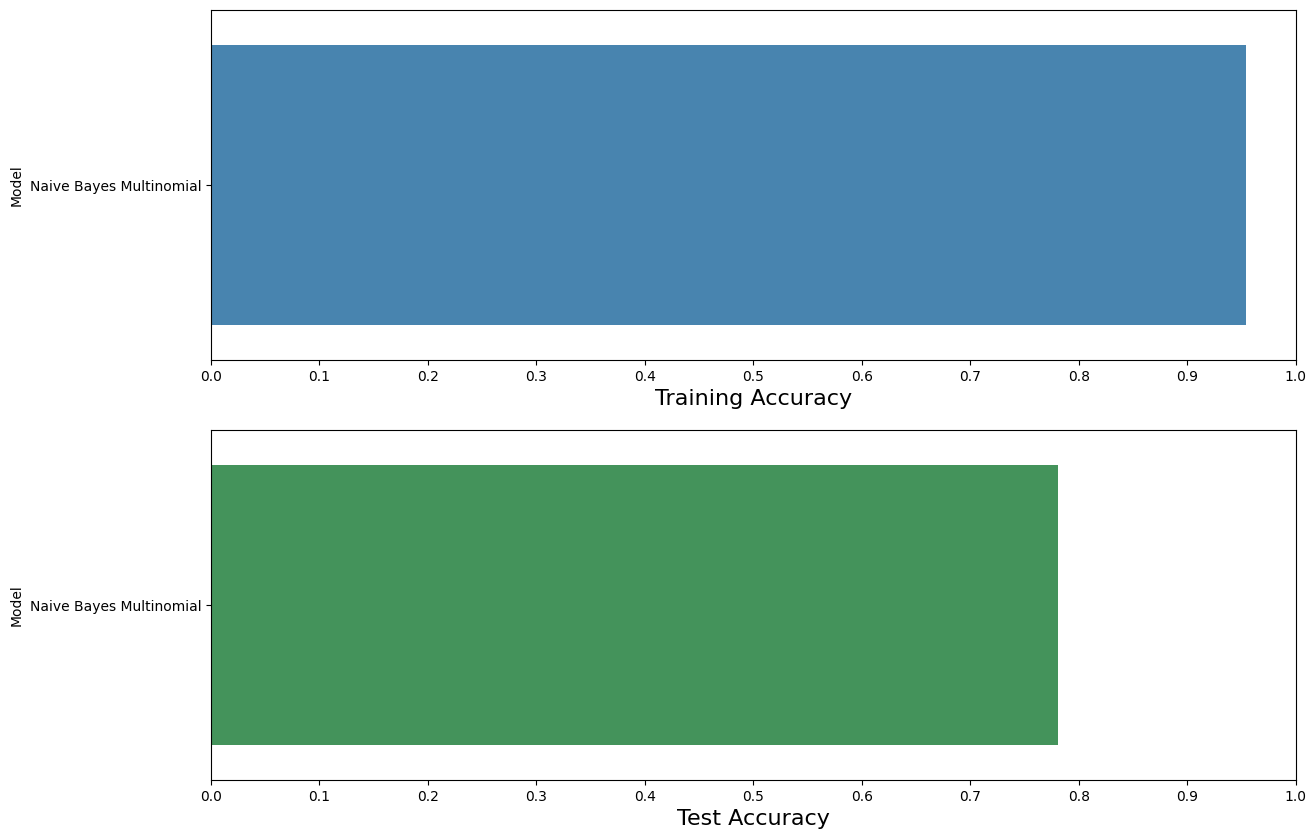

In [69]:
import numpy as np

f, axes = plt.subplots(2,1, figsize=(14,10))

predict.sort_values(by=['Training Accuracy'], ascending=False, inplace=True)

sns.barplot(x='Training Accuracy', y='Model', data = predict, palette='Blues_d', ax = axes[0])
#axes[0].set(xlabel='Region', ylabel='Charges')
axes[0].set_xlabel('Training Accuracy', size=16)
axes[0].set_ylabel('Model')
axes[0].set_xlim(0,1.0)
axes[0].set_xticks(np.arange(0, 1.1, 0.1))

predict.sort_values(by=['Test Accuracy'], ascending=False, inplace=True)

sns.barplot(x='Test Accuracy', y='Model', data = predict, palette='Greens_d', ax = axes[1])
#axes[0].set(xlabel='Region', ylabel='Charges')
axes[1].set_xlabel('Test Accuracy', size=16)
axes[1].set_ylabel('Model')
axes[1].set_xlim(0,1.0)
axes[1].set_xticks(np.arange(0, 1.1, 0.1))

plt.show()

# simpan kedalam joblib

In [70]:
import joblib

In [71]:
# save the model to disk
joblib.dump(classifier_nb.best_estimator_, 'classifier_nb.best_estimator_.sav', compress=1)

['classifier_nb.best_estimator_.sav']